In [1]:
from k1lib.imports import *

In [2]:
class SkipBlock(nn.Module):
    def __init__(self, hiddenDim=10):
        super().__init__()
        self.hiddenDim = hiddenDim
        def gen(): return nn.Linear(hiddenDim, hiddenDim), nn.LeakyReLU()
        self.seq = nn.Sequential(*gen(), *gen(), *gen())
    def forward(self, x):
        return self.seq(x) + x
class LinearBlock(nn.Module):
    def __init__(self, hiddenDim=10):
        super().__init__()
        self.hiddenDim = hiddenDim
        def gen(): return nn.Linear(hiddenDim, hiddenDim), nn.LeakyReLU()
        self.seq = nn.Sequential(*gen(), *gen(), *gen())
    def forward(self, x):
        return self.seq(x)
class Network(nn.Module):
    def __init__(self, hiddenDim=10, blocks=2, relu=True, block=SkipBlock):
        super().__init__()
        activation = lambda: nn.LeakyReLU() if relu else nn.Sigmoid()
        layers = []
        layers += [nn.Linear(1, hiddenDim), activation()]
        for i in range(blocks): layers += [block(hiddenDim)]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [3]:
def newL(bs=64, optF=None, *args, **kwargs):
    if optF == None: optF = lambda x: optim.SGD(x, lr=2e-4, momentum=0.9)
    if optF == "Adam": optF = lambda p: optim.Adam(p, lr=3e-3)
    l = k1lib.Learner()
    l.model = Network(*args, **kwargs)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optF(l.model.parameters())
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        #plt.plot(xbs, ybs, ".")
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    l.cbs.withCancelOnLowLoss(1, epochMode=True)
    return l

In [4]:
l = newL(optF="Adam", blocks=20, block=LinearBlock)
l.css = """LinearBlock #0: HookParam
LinearBlock: HookModule"""
l.run(10); l.save("linear.pth")

Progress: 100%, epoch:  9/10, batch: 156/157, elapsed:  26.57s  Saved to autosave-2.pth
Saved to linear.pth


In [5]:
l = newL(optF="Adam", blocks=20)
l.css = """SkipBlock #0: HookParam
SkipBlock: HookModule"""
l.run(10); l.save("skip.pth")

Progress:  30%, epoch:  2/10, batch: 155/157, elapsed:   7.79s  Run cancelled: Low loss 1 achieved!.
Saved to autosave-2.pth
Saved to skip.pth


## Analysis

So this is to compare performance between LinearBlock and SkipBlock.

In [6]:
skip = k1lib.Learner.load("skip.pth")
linear = k1lib.Learner.load("linear.pth")

Loaded from skip.pth
Loaded from linear.pth


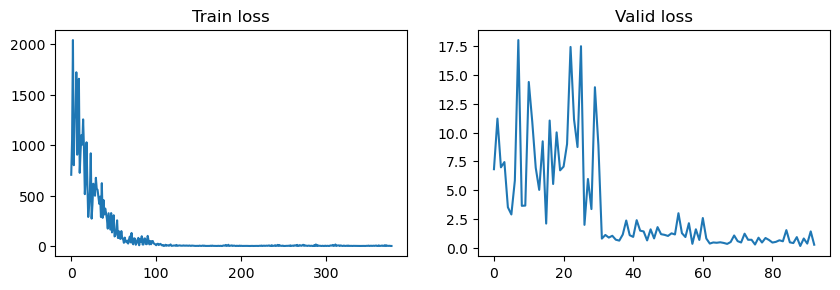

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [7]:
skip.Loss.plot()

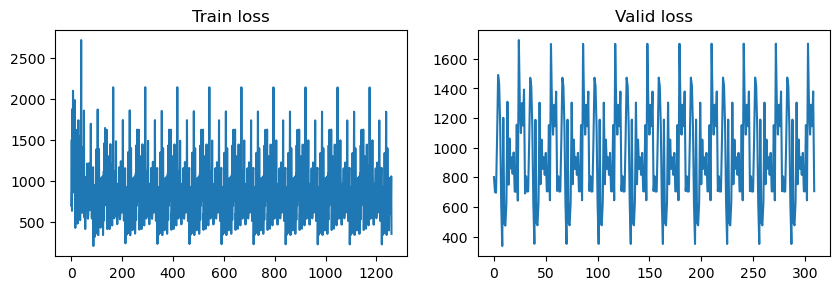

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [8]:
linear.Loss.plot()

So it's clear that SkipBlock can actually learn, while LinearBlock is just a pile of junk. I mean, look at this:

Epoch cancelled: .
Epoch cancelled: .


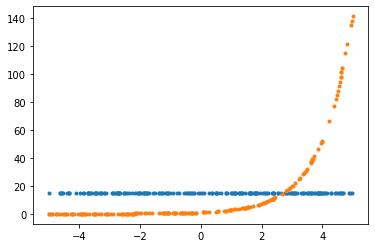

In [10]:
linear.evaluate(); skip.evaluate()

It's so bad that the network intentionally nulls out input, because that's the optimal strategy when beginning layers can't really change. So let's see that change:

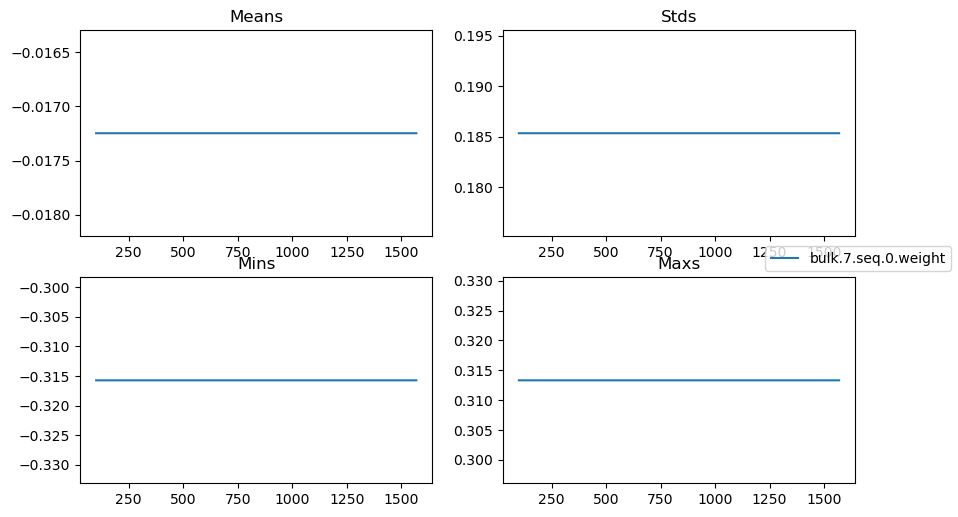

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [20]:
linear.HookParam[10].plot()[100:]

See, nothing. Let's look at HookModule:

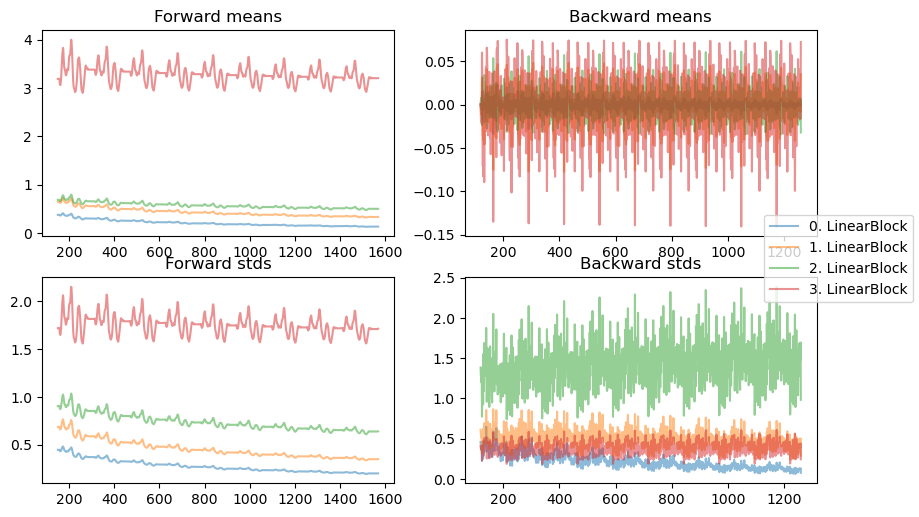

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [28]:
linear.HookModule[16:].plot()[150:] # final layers

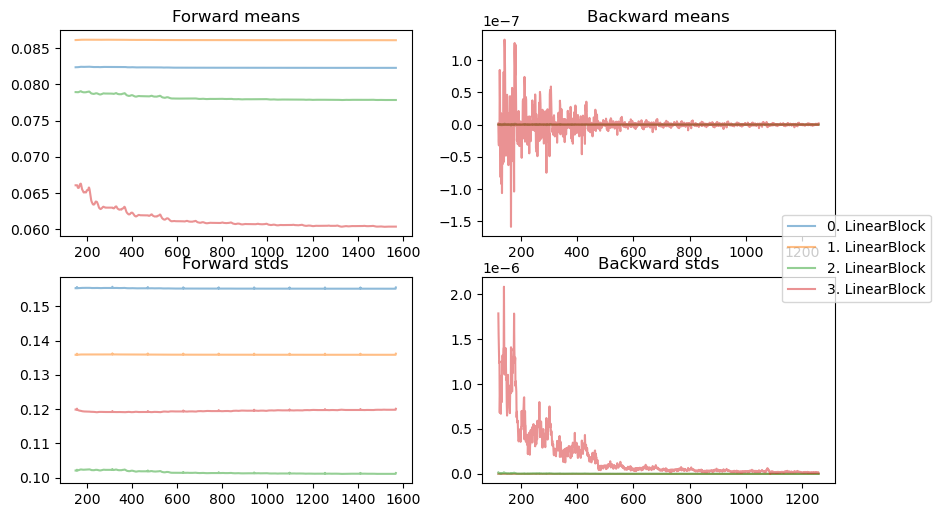

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [30]:
linear.HookModule[8:12].plot()[150:] # middle layers

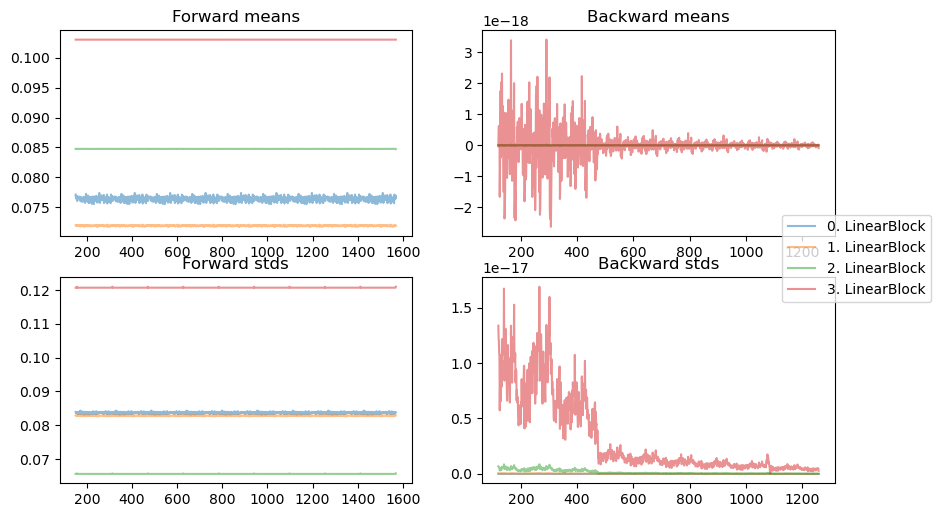

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [31]:
linear.HookModule[:4].plot()[150:] # beginning layers

Final layers looks fine though. Backward means and std still has a reasonable signal strength of $0.05 - 0.15$, which is expected. But for the middle layers, this drops down to $10^{-7} - 10^{-6}$, and for the beginning layers, it's $10^{-18} - 10^{-17}$. Holy smokes that's small. And it actively tries to get lower and lower over time too.


Progress: 100%          8/8 Finished [-3.2, 3.2] range                          

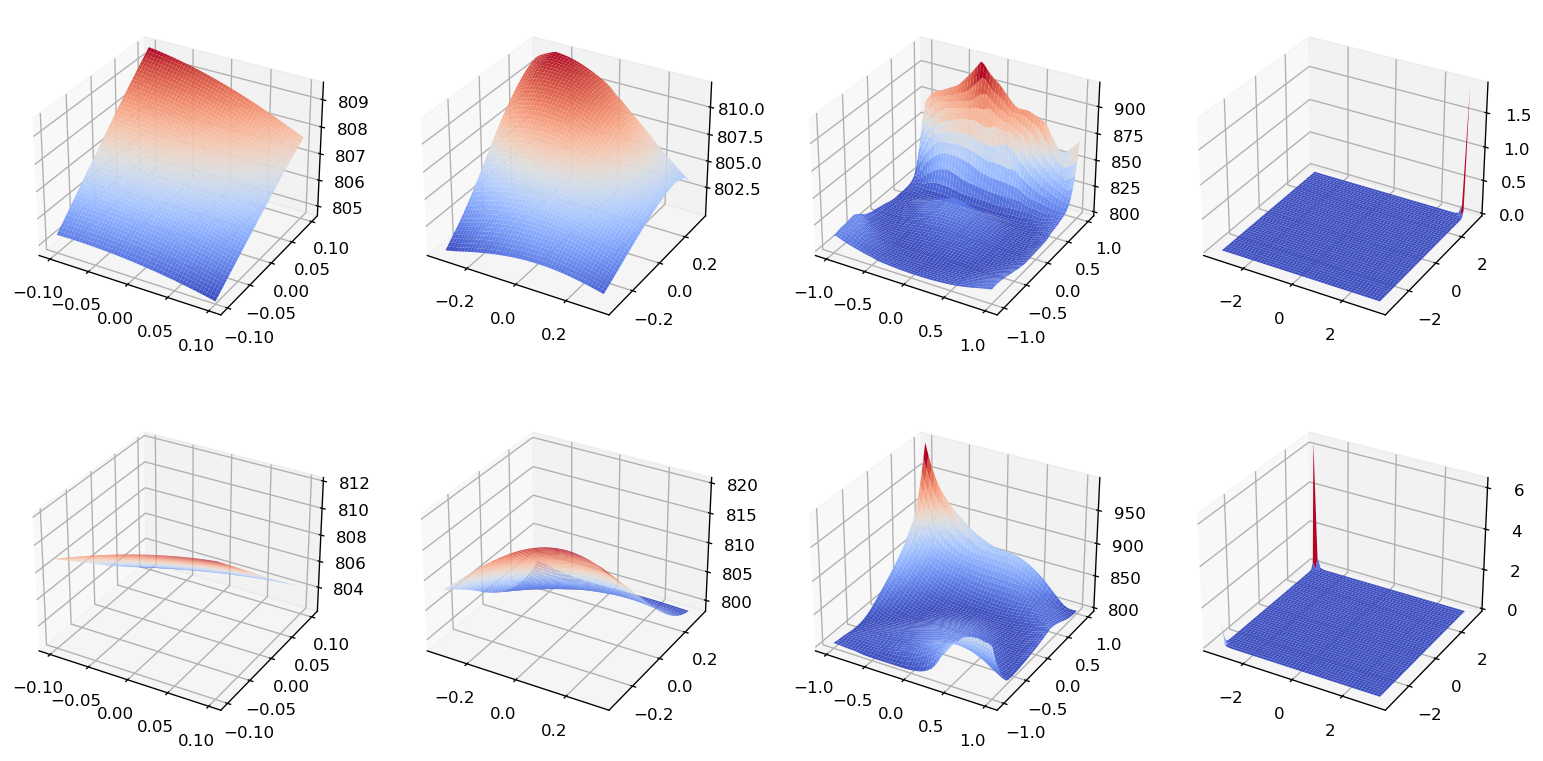

In [33]:
linear.LossLandscape.plot()

Also, the loss landscape sort of shows that the center point is sloped pretty hard, so it shouldn't be a problem for optimizers to optimize. But they can't do it. Even when using Adam, and even when using LeakyReLU. Let's see HookModule of the skip network:

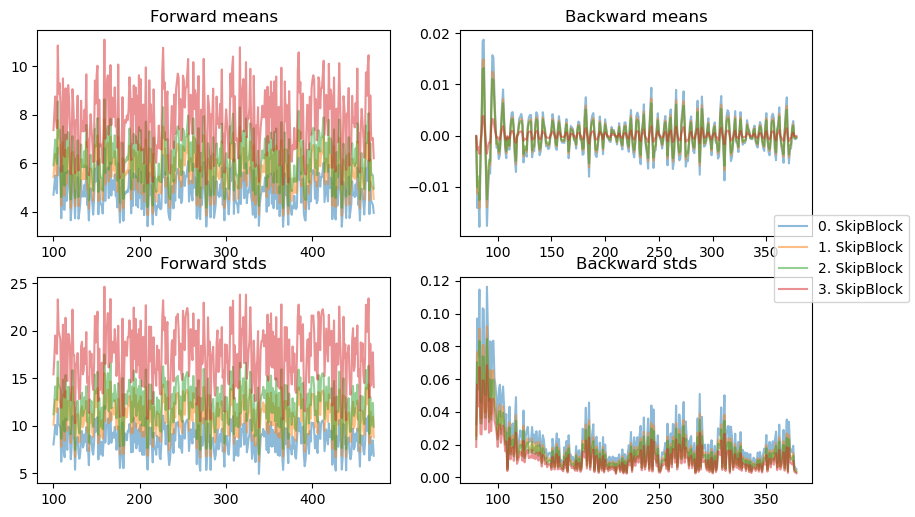

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [38]:
skip.HookModule[16:].plot()[100:] # final layers

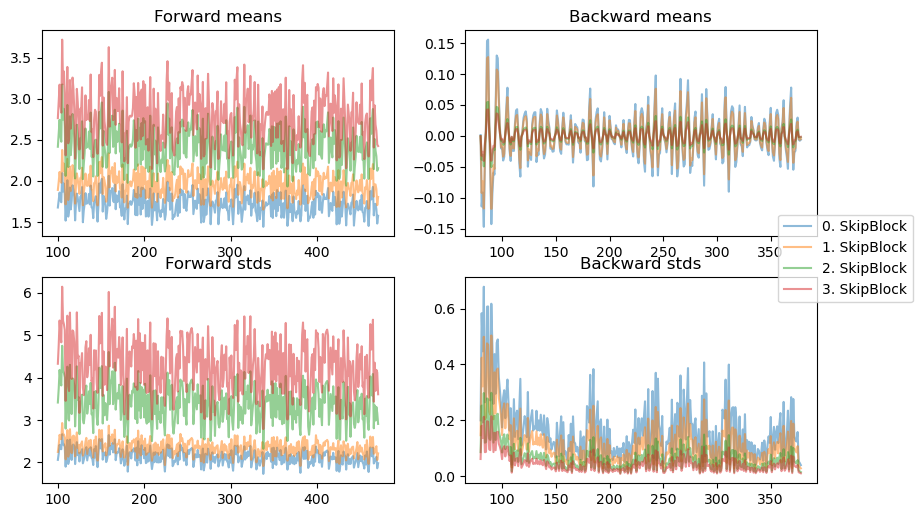

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [39]:
skip.HookModule[8:12].plot()[100:] # middle layers

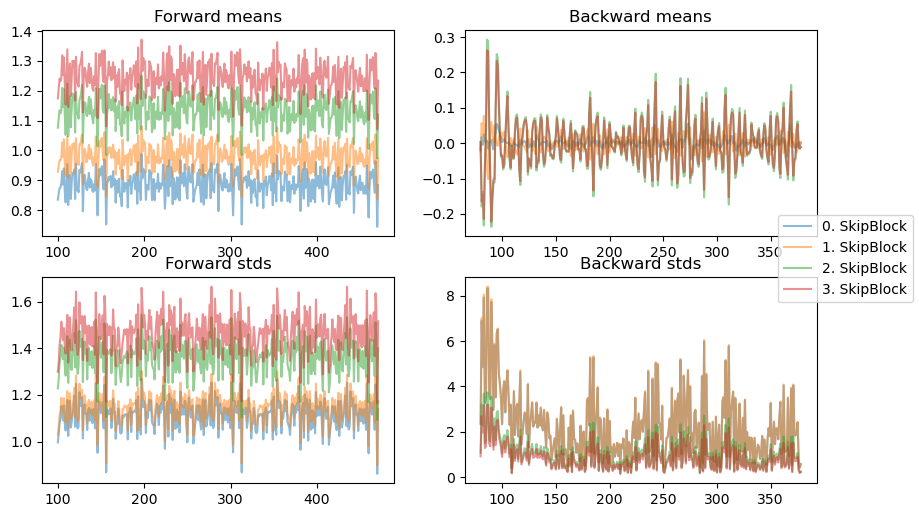

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [40]:
skip.HookModule[:4].plot()[100:] # beginning layers

Now this looks much, much more healthy. Final layers still have the same 0.02 range, kinda like with linear. It's a bit smaller, because the losses are also smaller, indicating that it has actually learn stuff. But notice how middle and beginning layers are like 10x larger. It doesn't explode though (when it can totally cross multiple orders of magnitude in linear network), just bigger, which is nice. Also those oscillating spikes I'm guessing is because the optimizer update is a wee bit large, so it can't actually settle down. So in that case, annealing the lr should be good.


Progress: 100%          8/8 Finished [-3.2, 3.2] range                               7/8 Finished [-1, 1] range       

/home/kelvin/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/kelvin/anaconda3/envs/torch/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


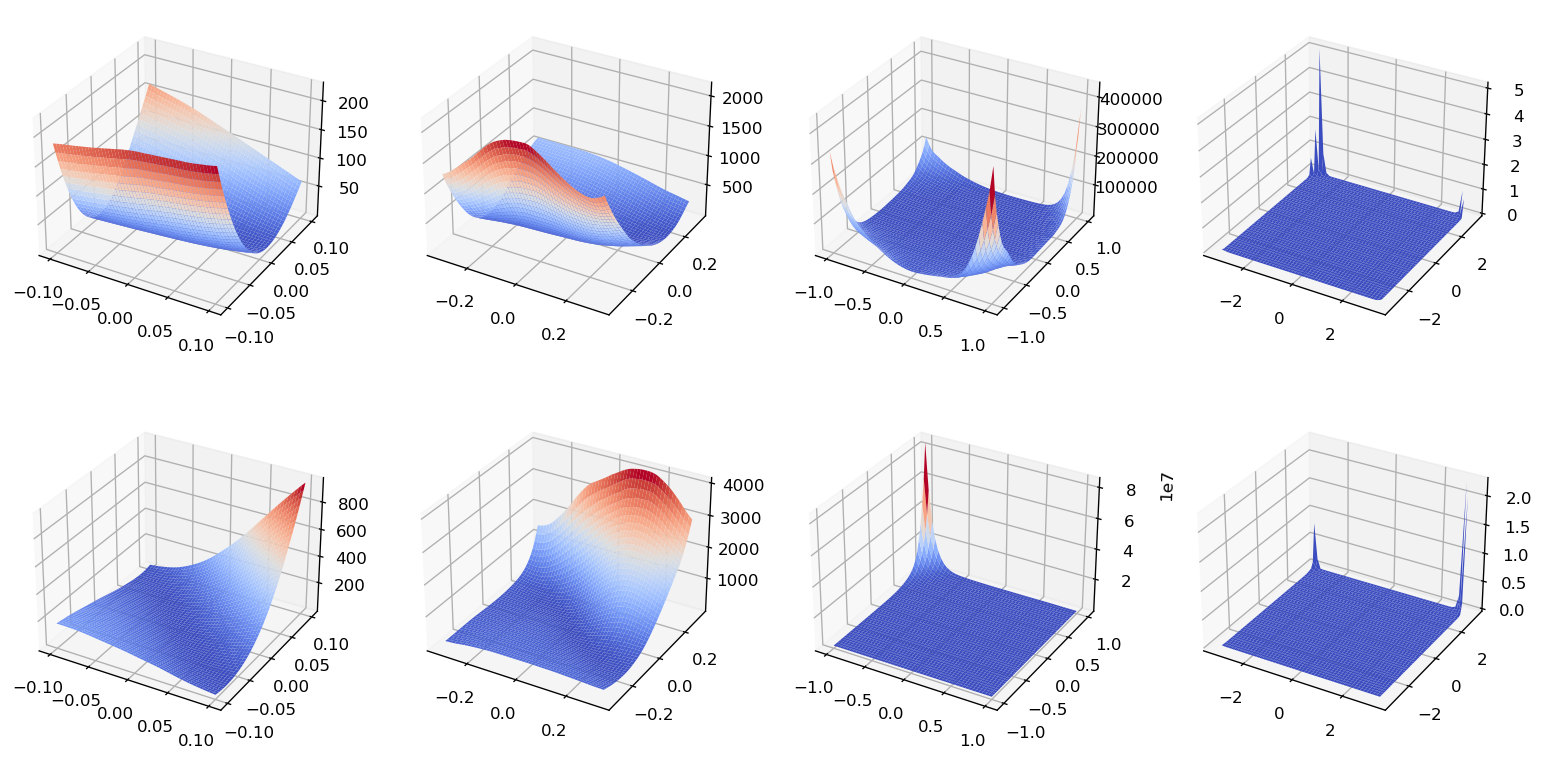

In [34]:
skip.LossLandscape.plot()

Also, the loss landscape sort of does indicate that it's always in a deep well, which is just what we want